In [65]:
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Loading Dataset

In [43]:
df = pd.read_csv(r"C:\Users\leduc\OneDrive\Desktop\bap tap uit\CS115\CS115-dataset\beophi.csv", index_col=0)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 773 entries, 0 to 772
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               773 non-null    int64  
 1   Glucose                   772 non-null    float64
 2   BloodPressure             773 non-null    int64  
 3   SkinThickness             773 non-null    int64  
 4   Insulin                   773 non-null    int64  
 5   BMI                       772 non-null    float64
 6   DiabetesPedigreeFunction  773 non-null    float64
 7   Age                       773 non-null    int64  
 8   Outcome                   773 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 60.4 KB


## Data cleaning 

In [45]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,773.000000,772.000000,773.000000,773.000000,773.000000,772.000000,773.000000,773.000000,773.000000
mean,3.824062,121.813472,69.952135,20.552393,79.380336,37.513342,0.469982,33.191462,0.351876
std,3.369336,40.868603,30.392494,15.927667,114.990798,155.004046,0.331145,11.744123,0.480568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,19.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.275000,0.240000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,25.000000,32.000000,0.370000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,126.000000,36.600000,0.624000,41.000000,1.000000
max,17.000000,830.000000,722.000000,99.000000,846.000000,4333.100000,2.420000,81.000000,2.000000


##### Như ta có thể thấy ở phần max của các cột BloodPressure, Insulin và BMI xuất hiện giá trị lớn bất thường
##### Giá trị outcome đáng lẽ phải là 0 hoặc 1 nhưng xuất hiện 2

In [87]:
df = df[df["BMI"] < 4333.1]
df[df["BMI"] >= 4333.1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [86]:
df = df[df["BloodPressure"] < 722]
df[df["BloodPressure"] >= 722]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [85]:
df = df[df["Glucose"] < 830]
df[df["Glucose"] >= 830]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [70]:
df = df[df["Outcome"] < 2]
df[df["Outcome"] >= 2]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [71]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Ở phần info phía trên không hề báo có Null values nhưng khi check lại bằng cách khác thì lại xuất hiện feature Glucose và BMI có Null Values

Để khắc phục vấn đề giá trị khuyết thiếu ta sẽ thử thực nghiệm trên 3 phương pháp.

- Drop luôn record bị khuyết
- Fill bằng giá trị 0
- Fill bằng giá trị trung bình toàn cục
- Fill bằng "KNN Imputer"

In [72]:
df_mean = df.copy(deep=True)
df_zero = df.copy(deep=True)
df_imputed = df.copy(deep=True)
df_drop = df.copy(deep=True)

In [73]:
df_zero['Glucose'] = df_zero['Glucose'].fillna(0)
df_zero['BMI'] = df_zero['BMI'].fillna(0)

df_zero.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [74]:
df_mean['Glucose'] = df_mean['Glucose'].fillna(df_mean['Glucose'].mean())
df_mean['BMI'] = df_mean['BMI'].fillna(df_mean['BMI'].mean())

df_mean.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [75]:
# uniform => các neighbors đều có trọng số như nhau
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [76]:
df_drop = df_drop.dropna()
df_drop.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Data splitting

In [77]:
y_zero = df_zero["Outcome"]  
x_zero = df_zero.drop(columns=["Outcome"], axis=1) 

In [101]:
y_drop = df_drop["Outcome"]  
x_drop = df_drop.drop(columns=["Outcome"], axis=1) 

In [98]:
y_mean = df_mean["Outcome"]  
x_mean = df_mean.drop(columns=["Outcome"], axis=1) 

In [99]:
y_imputed = df_imputed["Outcome"]  
x_imputed = df_imputed.drop(columns=["Outcome"], axis=1) 

In [102]:
x_train_zero, x_test_zero, y_train_zero, y_test_zero = train_test_split(x_zero, y_zero, test_size=0.2 ,random_state=221)
x_train_drop, x_test_drop, y_train_drop, y_test_drop = train_test_split(x_drop, y_drop, test_size=0.2 ,random_state=221)
x_train_mean, x_test_mean, y_train_mean, y_test_mean = train_test_split(x_mean, y_mean, test_size=0.2 ,random_state=221)
x_train_imputed, x_test_imputed, y_train_imputed, y_test_imputed = train_test_split(x_imputed, y_imputed, test_size=0.2 ,random_state=221)

## Training and Evaluating

In [104]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=221)
gb.fit(x_train_drop, y_train_drop)
y_pred = gb.predict(x_test_drop)

print(classification_report(y_test_drop, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.80        90
           1       0.74      0.62      0.67        65

    accuracy                           0.75       155
   macro avg       0.75      0.73      0.73       155
weighted avg       0.75      0.75      0.74       155



In [107]:
gb_zero = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=221)
gb_zero.fit(x_train_zero, y_train_zero)
y_pred = gb_zero.predict(x_test_zero)

print(classification_report(y_test_zero, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.80        90
           1       0.74      0.62      0.67        65

    accuracy                           0.75       155
   macro avg       0.75      0.73      0.73       155
weighted avg       0.75      0.75      0.74       155



In [108]:
gb_mean = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=221)
gb_mean.fit(x_train_mean, y_train_mean)
y_pred = gb_mean.predict(x_test_mean)

print(classification_report(y_test_mean, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.80        90
           1       0.74      0.62      0.67        65

    accuracy                           0.75       155
   macro avg       0.75      0.73      0.73       155
weighted avg       0.75      0.75      0.74       155



In [109]:
gb_imputed = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=221)
gb_imputed.fit(x_train_imputed, y_train_imputed)
y_pred = gb_imputed.predict(x_test_imputed)

print(classification_report(y_test_imputed, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.80        90
         1.0       0.74      0.62      0.67        65

    accuracy                           0.75       155
   macro avg       0.75      0.73      0.73       155
weighted avg       0.75      0.75      0.74       155



## Feature selection

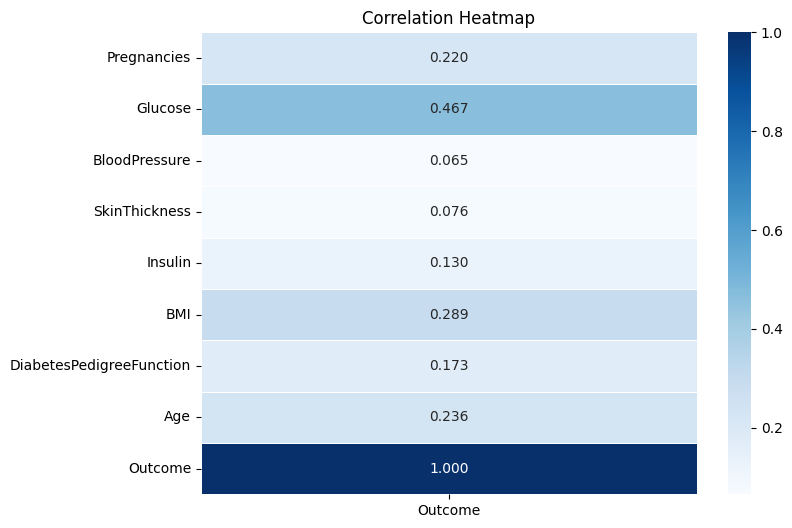

In [116]:
corr_matrix = df.corr()
corr_matrix = corr_matrix["Outcome"].to_frame()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [130]:
y_imputed = df_imputed["Outcome"]  
x_imputed = df_imputed.drop(columns=["Outcome"], axis=1)[["Pregnancies", "Glucose", "BMI", "Age"]] 

In [131]:
x_imputed.head()

,Pregnancies,Glucose,BMI,Age
0,6.0,148.0,33.6,50.0
1,1.0,85.0,26.6,31.0
2,8.0,183.0,23.3,32.0
3,1.0,89.0,28.1,21.0
4,0.0,137.0,43.1,33.0


In [132]:
x_train_imputed, x_test_imputed, y_train_imputed, y_test_imputed = train_test_split(x_imputed, y_imputed, test_size=0.2 ,random_state=221)

In [133]:
gb_imputed = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=221)
gb_imputed.fit(x_train_imputed, y_train_imputed)
y_pred = gb_imputed.predict(x_test_imputed)

print(classification_report(y_test_imputed, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82        90
         1.0       0.81      0.60      0.69        65

    accuracy                           0.77       155
   macro avg       0.78      0.75      0.76       155
weighted avg       0.78      0.77      0.77       155



Khi chỉ chọn các feature có correlation trên 0.2 với target thì accuracy tăng từ 0.75 -> 0.77